In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Ejercicio 2

In [4]:
# Elegimos la semilla
np.random.seed(263) # últimos tres dígitos del DNI

# Número de observaciones
n = 5000

# Generamos las edades para tratamiento y control
edad_tratamiento = np.random.normal(20, 2.5, int(n / 2))
edad_control = np.random.normal(25, 3, int(n / 2))
edad = np.concatenate((edad_tratamiento, edad_control))

# Generamos la experiencia para tratamiento y control
exper_tratamiento = np.random.normal(1.76, 0.5, int(n / 2))
exper_control = np.random.normal(2.3, 0.75, int(n / 2))
exper = np.concatenate((exper_tratamiento, exper_control))

# Variables centradas con respecto a la media
edad_c = edad - edad.mean()
exper_c = exper - exper.mean()

# Variables al cuadrado
edad_c2 = edad_c ** 2
exper_c2 = exper_c ** 2

# Producto cruzado
edadexper = edad_c * exper_c

# Variable de tratamiento
tratamiento = np.concatenate((np.ones(int(n / 2)), np.zeros(int(n / 2))))

# Error aleatorio
epsilon = np.random.normal(0, 0.5, n)

# Resultados potenciales
y0 = 15000 + 10.25 * edad_c + 10.5 * edad_c2 + 1000 * exper_c - 10.5 * exper_c2 + 500 * edadexper + epsilon
y1 = y0 + 2500 + 100 * edad_c + 1000 * exper_c

# Verdadero ATE y ATT
ate_verdadero = np.mean(y1 - y0)
att_verdadero = np.mean((y1 - y0)[tratamiento == 1])

print(f'El verdadero ATE es: {ate_verdadero:.2F}')
print(f'El verdadero ATT es: {att_verdadero:.2F}')

El verdadero ATE es: 2500.00
El verdadero ATT es: 1999.77


Simulación

In [5]:
# Listas para almacenar los resultados de las simulaciones
ate_resultados_a = [] # Modelo a)
ate_resultados_b = [] # Modelo b)

# Realizamos las
simulaciones = 1000
for _ in range(simulaciones):
    # Generamos el tratamiento aleatoriamente para garantizar que se cumpla independencia
    tratamiento_simulacion = np.random.choice([0, 1], size=n)
    
    # Modelo A: Saturación simple
    X_a = pd.DataFrame({'tratamiento': tratamiento_simulacion, 'edad_c': edad_c, 'experiencia_c': exper_c, 
                        'tratedad': tratamiento_simulacion*edad_c, 'tratexper': tratamiento_simulacion*exper_c,
                        'edad_experiencia': edadexper})
    X_a = sm.add_constant(X_a) # Añadimos la constante al modelo
    y_a = y1 * tratamiento_simulacion + y0 * (1 - tratamiento_simulacion) # Construimos la variable dependiente con el tratamiento aleatorio
    model_a = sm.OLS(y_a, X_a).fit()
    ate_a = model_a.params['tratamiento']
    ate_resultados_a.append(ate_a)

    # Modelo B: Efecto tratamiento homogéneo y regresión con términos cuadráticos e interacción
    X_b = pd.DataFrame({'tratamiento': tratamiento_simulacion, 'edad_c': edad_c, 'edad_c2': edad_c2,
                        'experiencia_c': exper_c, 'experiencia_c2': exper_c2, 'edad_c2edad_c': edad_c2*edad_c,
                         'edadexper': edadexper, 'edad_cexper_c2': edad_c*exper_c2, 'edad_c2exper_c': edad_c2*exper_c,
                         'edad_c2exper_c2': edad_c2*exper_c2, 'exper_cexper_c2': exper_c*exper_c2,
                         'edad_c2edad_cexper_c': edad_c2*edad_c*exper_c, 'edad_c2edad_c_exper_c2': edad_c2*edad_c*exper_c2,
                         'tratedad_c': tratamiento_simulacion*edad_c, 'tratedad_c2': tratamiento_simulacion*edad_c2,
                         'tratexper_c': tratamiento_simulacion*exper_c, 'tratexper_c2': tratamiento_simulacion*exper_c2,
                         'tratedad_c2edad_c': tratamiento_simulacion*edad_c2*edad_c, 
                         'tratedadexper': tratamiento_simulacion*edadexper, 
                         'tratedad_cexper_c2': tratamiento_simulacion*edad_c*exper_c2,
                         'tratedad_c2exper_c': tratamiento_simulacion*edad_c2*exper_c,
                         'tratedad_c2exper_c2': tratamiento_simulacion*edad_c2*exper_c2,
                         'tratexper_cexper_c2': tratamiento_simulacion*exper_c*exper_c2,
                         'tratedad_c2edad_cexper_c': tratamiento_simulacion*edad_c2*edad_c*exper_c,
                         'tratedad_c2edad_cexper_c2': tratamiento_simulacion*edad_c2*edad_c*exper_c2})
    X_b = sm.add_constant(X_b) # Añadimos la constante al modelo
    y_b = y1 * tratamiento_simulacion + y0 * (1 - tratamiento_simulacion) # Construimos la variable dependiente con el tratamiento aleatorio
    model_b = sm.OLS(y_b, X_b).fit()
    ate_b = model_b.params['tratamiento']
    ate_resultados_b.append(ate_b)

# Promedio de las estimaciones del ATE en ambas simulaciones
ate_promedio_a = np.mean(ate_resultados_a)
ate_promedio_b = np.mean(ate_resultados_b)

print(f'El promedio de la estimación del ATE en las {simulaciones} simulaciones para el modelo a) es: {ate_promedio_a:.2F}')
print(f'El promedio de la estimación del ATE en las {simulaciones} simulaciones para el modelo b) es: {ate_promedio_b:.2F}')

El promedio de la estimación del ATE en las 1000 simulaciones para el modelo a) es: 2500.01
El promedio de la estimación del ATE en las 1000 simulaciones para el modelo b) es: 2500.00


Gráficos

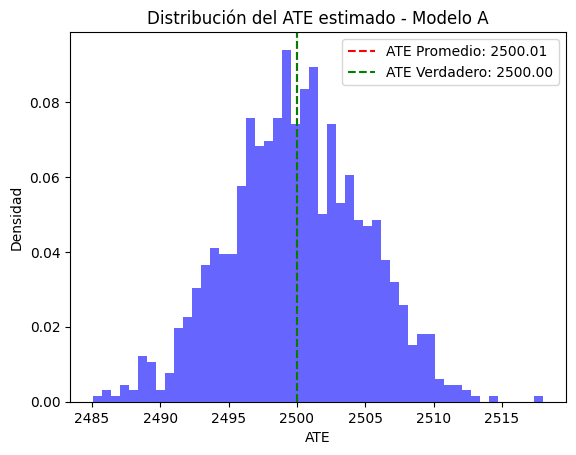

In [6]:
# Gráfico de densidad para el modelo A
plt.hist(ate_resultados_a, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(x=ate_promedio_a, color='red', linestyle='--', label=f'ATE Promedio: {ate_promedio_a:.2f}')
plt.axvline(x=ate_verdadero, color='green', linestyle='--', label=f'ATE Verdadero: {ate_verdadero:.2f}')
plt.xlabel('ATE')
plt.ylabel('Densidad')
plt.title('Distribución del ATE estimado - Modelo A')
plt.legend()
plt.show()

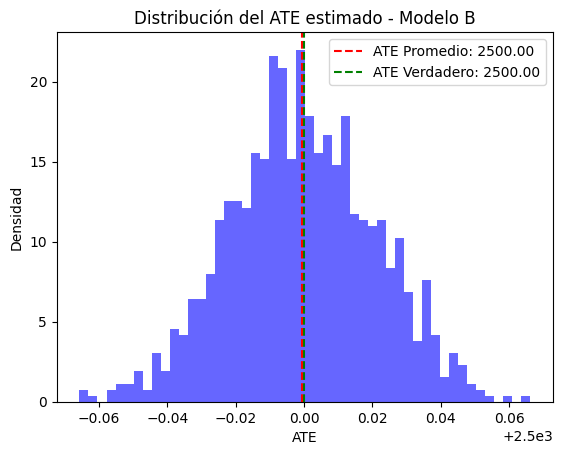

In [7]:
# Gráfico de densidad para el modelo B
plt.hist(ate_resultados_b, bins=50, density=True, alpha=0.6, color='b')
plt.axvline(x=ate_promedio_b, color='red', linestyle='--', label=f'ATE Promedio: {ate_promedio_b:.2f}')
plt.axvline(x=ate_verdadero, color='green', linestyle='--', label=f'ATE Verdadero: {ate_verdadero:.2f}')
plt.xlabel('ATE')
plt.ylabel('Densidad')
plt.title('Distribución del ATE estimado - Modelo B')
plt.legend()
plt.show()